In [11]:
"""
Final Python script for visualizing satellite data using the Community Earth System model (CESM).
This script was developed under the supervision of Dr. Marysa Laguë as one of the final components of Andre Bergeron's 
summer 2024 research project for the Research Experience in ALpine Meteorology (REALM) REU program at the University of Utah
"""

# August 1st, 2024 | Andre Bergeron | Data retrieved from Dr. Marysa Laguë, PhD. | University of Utah, Department of Atmospheric Sciences  
# This research was supported by the National Science Foundation (Award #2244272) and the Center for High Performance Computing (CHPC) at the University of Utah
# Final energy flux plots for the Pacific North/south east and Atlantic North/south east National Ecological Observatory Network (NEON) Domains

"\nFinal Python script for visualizing satellite data using the Community Earth System model (CESM).\nThis script was developed under the supervision of Dr. Marysa Laguë as one of the final components of Andre Bergeron's \nsummer 2024 research project for the Research Experience in ALpine Meteorology (REALM) REU program at the University of Utah\n"

In [12]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt

sys.path.append('./scripts')

import datetime
import glob
import multiprocessing
import os
import pickle as pickle
import sys
import time
from copy import copy

import cartopy
import cartopy.crs as ccrs
import cftime
import dask
import dask.bag as db
import IPython.core.display as di  
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.axes_size as Size
import netCDF4 as nc
import numpy as np
import numpy.ma as mak
import numpy.matlib
import pandas as pd
import scipy as sp
import scipy.io as sio
import xarray as xr
from cartopy.util import add_cyclic_point
from IPython.display import HTML, display

from matplotlib import gridspec, ticker
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
from numpy import ma
from scipy import interpolate, stats
from shapely.geometry.polygon import LinearRing
from sklearn import linear_model
from windspharm.standard import VectorWind

In [13]:
"""
Function computes the difference between the normal distribution of trees (trees) with a simulated tree die-off scenario (notrees)
and plots the results onto a bar graph using matplotlib
"""

'\nFunction computes the difference between the normal distribution of trees (trees) with a simulated tree die-off scenario (notrees)\nand plots the results onto a bar graph using matplotlib\n'

In [14]:
def energy_plot(ds_notrees, ds_trees, NEON_lat, NEON_lon, case_name):

    ### Define control (normal disribution of trees) and experiment (simulated no trees scenario) variables 
    ds_notrees = ds_notrees.sel(lat=NEON_lat, method='nearest').sel(lon=NEON_lon, method='nearest') 
    ds_trees = ds_trees.sel(lat=NEON_lat, method='nearest').sel(lon=NEON_lon, method='nearest') 
    
    ### compute the difference of the mean energy flux values between the control and experiment variables 
    delta_LH = (ds_notrees['LHFLX'].mean('time') - ds_trees['LHFLX'].mean('time').values)
    delta_SH = (ds_notrees['SHFLX'].mean('time') - ds_trees['SHFLX'].mean('time').values)
    
    delta_LWD = (ds_notrees['FLDS'].mean('time') - ds_trees['FLDS'].mean('time').values)
    delta_LWU = ((ds_notrees['FLDS']-ds_notrees['FLNS']).mean('time') - (ds_trees['FLDS'] - ds_trees['FLNS']).mean('time').values) 
    delta_SWD = (ds_notrees['FSDS'].mean('time') - ds_trees['FSDS'].mean('time').values) 
    delta_SWU = ((ds_notrees['FSDS'] - ds_notrees['FSNS']).mean('time') - (ds_trees['FSDS'] - ds_trees['FSNS']).mean('time').values)
    
    fig, ax = plt.subplots()

    ### Initialize and compute energy flux names, bar colors, and values to be used in bar graphs 
    flux_names = ['Latent Heat', 'Sensible Heat', 'Longwave down', 'Longwave up', 'Shortwave down', 'Shortwave up']       
    flux_values = [delta_LH.values, delta_SH.values, delta_LWD.values, delta_LWU.values, delta_SWD.values, delta_SWU.values]               
    bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple', 'tab:pink']
    
    bars = []
    for name, value, color in zip(flux_names, flux_values, bar_colors):
        bars.append(ax.bar(name, np.sum(value), color=color, width=0.8))
    
    ### Add bar graph components
    ax.set_ylabel('$\Delta$ Energy [W/m$^2$]', fontsize=18)
    plt.xticks(rotation=45)                        
    ax.set_title('%s (lat=%1.0f, lon=%1.0f)'%(case_name,NEON_lat,NEON_lon), fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', labelsize=14)
    plt.grid()
    plt.show()
    plt.close()
    

In [15]:
# Declare new variables with strings that dictate which section of the data is to be used
neon_path = '/uufs/chpc.utah.edu/common/home/lague-group1/data/EAGER'
ctrl_name = 'ctrl_smallpert'
NW_name = 'nd16'
SW_name = 'nd17'
SE_name = 'nd3'
NE_name = 'nd1'

In [16]:
# Declare new variables where the data for the case files (each NEON domain) and the control file (trees) is stored
ctrl_files_atm = sorted(glob.glob(neon_path + '/' + ctrl_name + '/means_100/*.cam.h0.20-99_year*.nc'))
case_files_atm_NW = sorted(glob.glob(neon_path + '/' + NW_name + '/means_100/*.cam.h0.20-99_year*.nc'))
case_files_atm_SW = sorted(glob.glob(neon_path + '/' + SW_name + '/means_100/*.cam.h0.20-99_year*.nc'))

case_files_atm_SE = sorted(glob.glob(neon_path + '/' + NW_name + '/means_100/*.cam.h0.20-99_year*.nc'))
case_files_atm_NE = sorted(glob.glob(neon_path + '/' + SW_name + '/means_100/*.cam.h0.20-99_year*.nc'))

In [17]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
  
    # open each case (NEON domain) filepaths and the control filepath
    ds_ctrl_atm = xr.open_mfdataset(ctrl_files_atm)
    ds_case_atm_NW = xr.open_mfdataset(case_files_atm_NW)
    ds_case_atm_SW = xr.open_mfdataset(case_files_atm_SW)
    ds_case_atm_SE = xr.open_mfdataset(case_files_atm_SE)
    ds_case_atm_NE = xr.open_mfdataset(case_files_atm_NE)
    
    #assign the lat and lon coordinate units from the control filepath to each NEON domain case filepaths  
    ds_case_atm_NW = ds_case_atm_NW.assign_coords({'lat':ds_ctrl_atm.lat.values,'lon':ds_ctrl_atm.lon.values})
    ds_case_atm_SW = ds_case_atm_SW.assign_coords({'lat':ds_ctrl_atm.lat.values,'lon':ds_ctrl_atm.lon.values})
    ds_case_atm_SE = ds_case_atm_SE.assign_coords({'lat':ds_ctrl_atm.lat.values,'lon':ds_ctrl_atm.lon.values})
    ds_case_atm_NE = ds_case_atm_NE.assign_coords({'lat':ds_ctrl_atm.lat.values,'lon':ds_ctrl_atm.lon.values})
    
    # merge case filepaths and control filepath 
    ds_case_NW = xr.merge([ds_case_atm_NW])
    ds_case_SW = xr.merge([ds_case_atm_SW])
    ds_case_SE = xr.merge([ds_case_atm_SE])
    ds_case_NE = xr.merge([ds_case_atm_NE])
    
    ds_ctrl = xr.merge([ds_ctrl_atm])

In [18]:
"""
Call energy_plot function to compute the notrees-trees simulation using coordinates to 
determine which gridcell within each of the four NEON domains the simulation will take place in.
"""

'\nCall energy_plot function to compute the notrees-trees simulation using coordinates to \ndetermine which gridcell within each of the four NEON domains the simulation will take place in.\n'

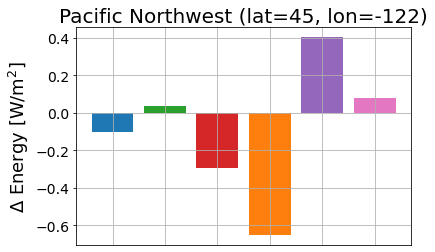

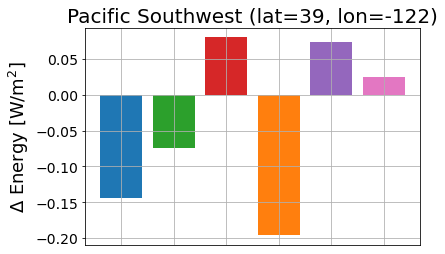

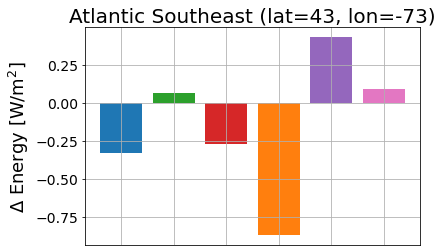

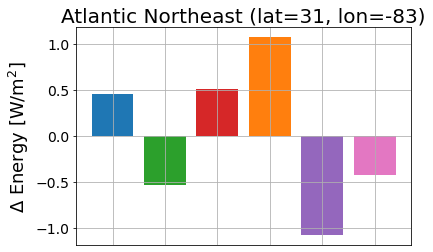

In [19]:
cases = [ds_case_NW, ds_case_SW, ds_case_SE, ds_case_NE]

domains = ['Pacific Northwest', 'Pacific Southwest', 'Atlantic Southeast', 'Atlantic Northeast']

latitudes = [45, 39, 43, 31]
longitudes = [-122, -122, -73, -83]

for x in range(len(domains)):
        
    energy_plot(cases[x], ds_ctrl, latitudes[x], longitudes[x], domains[x])